In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [12]:
df = pd.read_csv("clean_data.csv", index_col=0, low_memory=False)
df

,appid,name,review_score,total_positive,total_negative,total_reviews,type,required_age,is_free,short_description,...,Video Production,Casual,Sexual Content,Photo Editing,Action,Design & Illustration,Audio Production,Nudity,Utilities,Software Training
0,1648390,ScooterFlow,8,446,21,467,game,0,False,The world’s most realistic freestyle scooter g...,...,0,1,0,0,0,0,0,0,0,0
1,1648610,Malum,6,146,53,199,game,0,False,Malum is the premier C-list horror game. Run f...,...,0,0,0,0,1,0,0,0,0,0
2,1647962,Hell Let Loose – Lethal Tide,8,70,6,76,dlc,0,False,Unlock access to the Lethal Tide DLC.,...,0,0,0,0,1,0,0,0,0,0
3,1647550,NEO: The World Ends with You,8,224,11,235,game,0,False,&quot;Only the possibility of you can change o...,...,0,0,0,0,1,0,0,0,0,0
4,1647730,Zool Redimensioned,8,68,2,70,game,0,False,The Ninja of the Nth Dimension is back! Explor...,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,1490117,Train Sim World 2: Rush Hour - Boston Sprinter,5,45,24,69,dlc,0,False,"Experience the fastest rail line in America, f...",...,0,0,0,0,0,0,0,0,0,0
3220,540340,Resident Evil 7 - Season Pass,5,80,48,128,dlc,18,False,Purchase the Resident Evil 7 biohazard Season ...,...,0,0,0,0,1,0,0,0,0,0
3221,209670,Cortex Command,8,984,242,1226,game,0,False,"Choose between different factions, with their ...",...,0,0,0,0,1,0,0,0,0,0
3222,933060,Hentai Weed PuZZles,6,38,12,50,game,0,False,This is a jigsaw puzzle game in which you need...,...,0,1,0,0,0,0,0,0,0,0


-112.08715243636942 1367.2963801127294


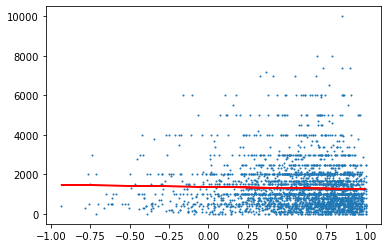

In [13]:
# calculate score
score = (df.total_positive - df.total_negative)/df.total_reviews

plt.scatter(score, df.price, s = 1)

# calculate linear regression
m, b = np.polyfit(score, df.price, 1)
print(m, b)

# regression line
plt.plot(score, m*score+b, color='red')